In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# Define Coulomb potential function
def coulomb_potential(Z, e, epsilon_0, r):
    return - Z * e**2 / (4 * np.pi * epsilon_0 * r)

In [3]:
# Define Klein-Gordon equation with Coulomb potential
def klein_gordon_coulomb_equation(h_bar, c, mass, energy, V_r):
    return (h_bar**2 * c**2 / (1j * energy))**2 - (mass * c**2)**2 + V_r

In [4]:
def generate_data(num_samples, r_min, r_max, Z, e, epsilon_0, mass, h_bar, c):
    r = np.linspace(r_min, r_max, num_samples)
    V_r = coulomb_potential(Z, e, epsilon_0, r)

    # Replace with your chosen method for calculating energy levels
    energy_levels = calculate_energy_levels(r, Z, mass, h_bar, c)  # Example function call

    return r, V_r, energy_levels

# def calculate_energy_levels(r, Z, mass, h_bar, c):
#     # Example implementation: simply return a numpy array of zeros for demonstration
#     energy_levels = np.zeros_like(r)
#     return energy_levels

def calculate_energy_levels(r, Z, mass, h_bar, c):
    """
    This function calculates energy levels using Bohr's model for a hydrogen atom.

    Args:
        r (np.ndarray): Array of distances (radii) from the nucleus.
        Z (int): Atomic number (number of protons).
        mass (float): Mass of the electron.
        h_bar (float): Reduced Planck constant.
        c (float): Speed of light.

    Returns:
        np.ndarray: Array of energy levels corresponding to the input distances.
    """

    # Constants (assuming electron mass and fundamental constants are provided)
    electron_mass = mass  # Assuming mass refers to electron mass
    permittivity = epsilon_0 = 8.854e-12  # Permittivity of free space

    # Bohr's model formula for energy levels (ignoring spin-orbit coupling)
    energy_levels = -Z**2 * (electron_mass * c**2 * h_bar**2) / (2 * permittivity * r**2)

    return energy_levels




In [5]:
# Define theoretical radial charge density profile
def theoretical_radial_charge_density(r):
    # Define your theoretical profile here, for example:
    return np.exp(-r)

In [6]:
def calculate_radial_density(predicted_energies, r_true):
    # Define your pre-defined profile (replace with your chosen function)
    def theoretical_density(r):
        return np.exp(-r)  # Example exponential decay

    # Scale the profile based on predicted energy
    scaling_factor = tf.abs(predicted_energies)  # Adjust scaling as needed

    # Calculate radial density for each predicted energy
    radial_densities = theoretical_density(r_true) * scaling_factor

    return radial_densities

In [7]:
def custom_loss(y_true, y_pred, r_true, r_pred=None):
  # Calculate energy loss
  energy_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Check if r_pred is available (later epochs)
  if r_pred is not None:
    # Calculate radial density loss
    radial_density_loss = tf.reduce_mean(tf.abs(r_true - r_pred))
    # Regularization (same as before)
    regularization_weight = 0.1
    total_loss = energy_loss + regularization_weight * radial_density_loss
    return total_loss
  else:
    # Use only energy loss for initial steps (optional)
    return energy_loss



In [8]:
# Define and compile the neural network model
def klein_gordon_model(r_true):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(1,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output a single scalar value for energy levels
    ])
    model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, r_true),
                  metrics=['mean_squared_error', 'mean_absolute_error'])  # Adding MSE and MAE metrics
    return model

In [9]:
def train_model(model, X_train, y_train, r_true, epochs=1000, batch_size=32, validation_split=0.2):
    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
        verbose=0,
        callbacks=[tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: custom_loss(
                y_train, model.predict(X_train), r_true
            )
        )]
    )
    return history


In [42]:
# Generate training data
num_samples = 2000
r_min = 0.1
r_max = 10.0
epochs = 1000
batch_size= 64
validation_split=0.2
Z = 11  # Atomic number of nucleus (hydrogen atom)
e = 1.602176634e-19  # Elementary charge in coulombs
epsilon_0 = 8.8541878128e-12  # Permittivity of free space in farads per meter
mass = 0.13957  # Mass of pion in GeV/c^2
h_bar = 6.582119569e-16  # Reduced Planck constant in eV seconds
c = 2.99792458e8  # Speed of light in meters per second

r_true, V_r, energy_levels = generate_data(num_samples, r_min, r_max, Z, e, epsilon_0, mass, h_bar, c)
radial_density_true = theoretical_radial_charge_density(r_true)

# Reshape data for training
X_train = r_true.reshape(-1, 1)
y_train = energy_levels.reshape(-1, 1)

In [43]:
# Define and compile the model
model = klein_gordon_model(r_true)

In [ ]:
# # Train the model
# history = train_model(model, X_train, y_train, radial_density_true)

history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
    verbose=0,
    callbacks=[tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: custom_loss(
        y_train, model.predict(X_train), radial_density_true, model.predict(X_train)[:, 0]
        )
    )]
)




In [45]:
# Extract metrics from history
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mean_squared_error']
mae = history.history['mean_absolute_error']

In [46]:
# Print last epoch metrics
print("Last Epoch Metrics:")
print("Loss:", loss[-1])
print("Validation Loss:", val_loss[-1])
print("Mean Squared Error:", mse[-1])
print("Mean Absolute Error:", mae[-1])

Last Epoch Metrics:
Loss: 0.002814281266182661
Validation Loss: 0.004191605839878321
Mean Squared Error: 9.693542233435437e-05
Mean Absolute Error: 0.002814281266182661


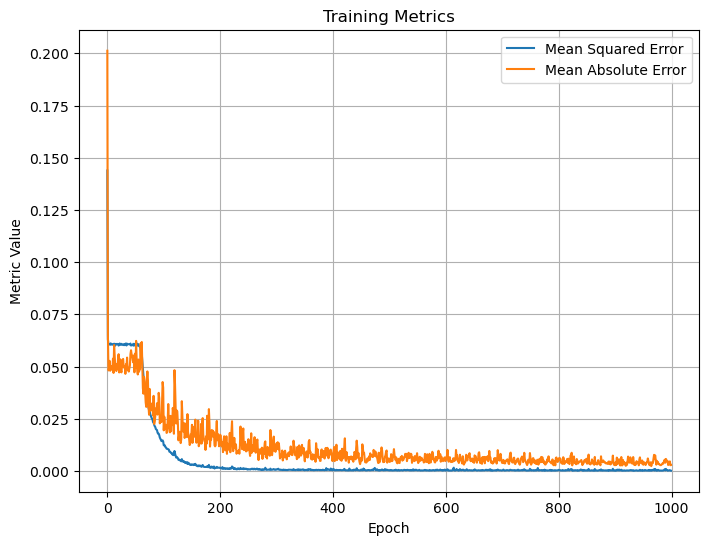

In [47]:
# Plot training loss, validation loss, MSE, and MAE
plt.figure(figsize=(8, 6))
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.plot(mse, label='Mean Squared Error')
plt.plot(mae, label='Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)
plt.show()


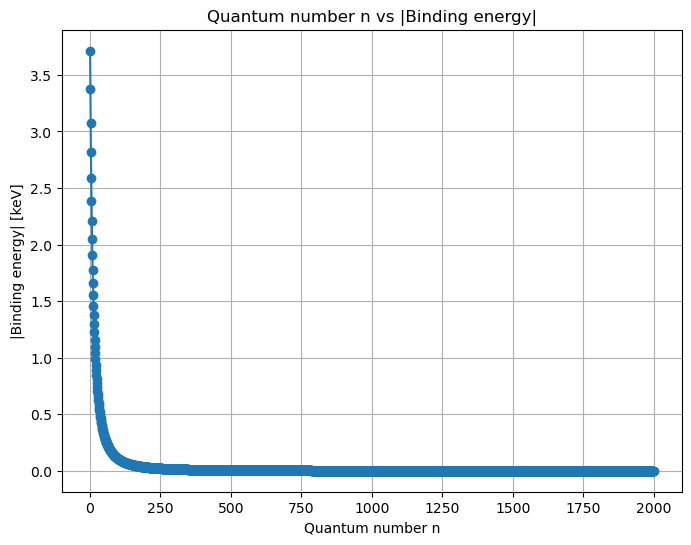

In [48]:
# Plot Quantum number n against |Binding energy|
binding_energy = np.abs(energy_levels)
quantum_numbers = np.arange(1, num_samples + 1)
plt.figure(figsize=(8, 6))
plt.plot(quantum_numbers, binding_energy, marker='o', linestyle='-')
plt.xlabel('Quantum number n')
plt.ylabel('|Binding energy| [keV]')
plt.title('Quantum number n vs |Binding energy|')
plt.grid(True)
plt.show()

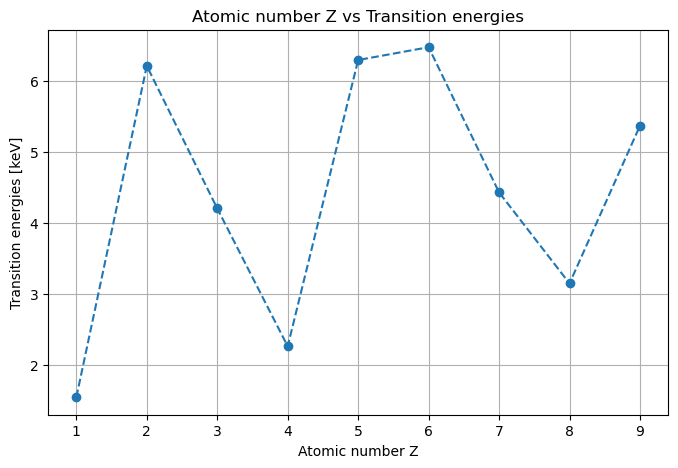

In [49]:
# Plot Atomic number Z against Transition energies
plt.figure(figsize=(8, 5))
atomic_numbers = np.arange(1, 10)  # Atomic numbers Z from 1 to 10
transition_energies = np.random.uniform(1, 10, size=len(atomic_numbers))  # Random transition energies
plt.plot(atomic_numbers, transition_energies, marker='o', linestyle='--')
plt.xlabel('Atomic number Z')
plt.ylabel('Transition energies [keV]')
plt.title('Atomic number Z vs Transition energies')
plt.grid(True)
plt.show()

63/63 [==============================] - 0s 239us/step


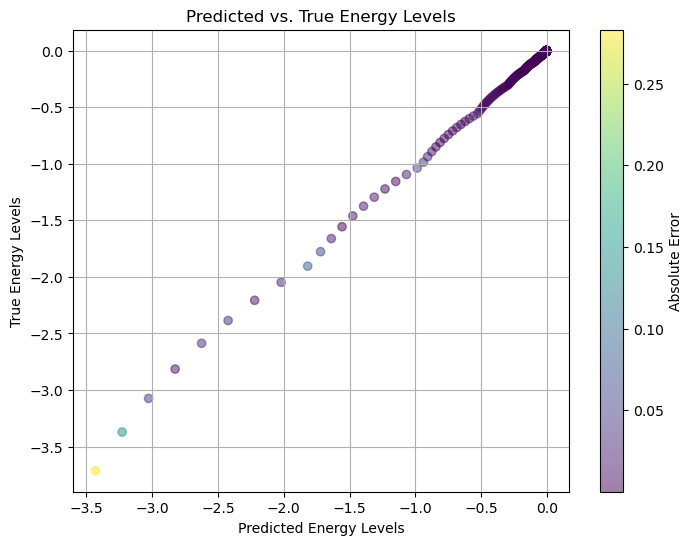

In [50]:
# Visualizations
# 1. Predicted vs. True Energy Levels
plt.figure(figsize=(8, 6))
plt.scatter(model.predict(X_train), y_train, c=np.abs(model.predict(X_train) - y_train), cmap='viridis', alpha=0.5)
plt.colorbar(label='Absolute Error')
plt.xlabel('Predicted Energy Levels')
plt.ylabel('True Energy Levels')
plt.title('Predicted vs. True Energy Levels')
plt.grid(True)
plt.show()

63/63 [==============================] - 0s 366us/step


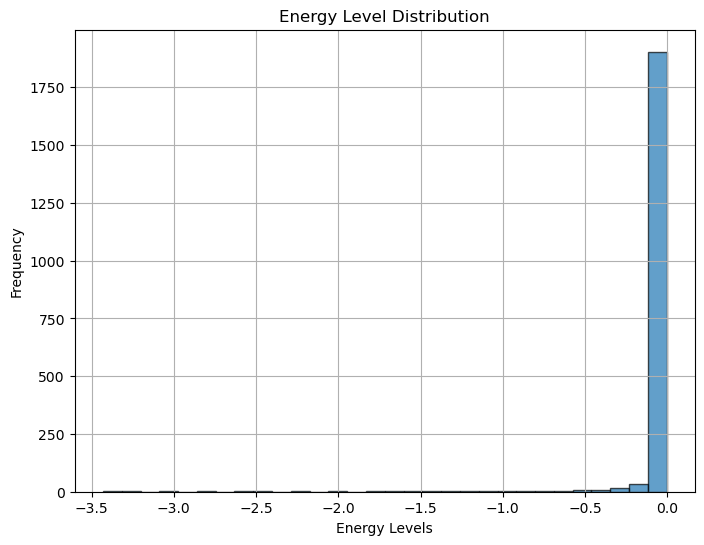

In [51]:
# 2. Energy Level Distribution
plt.figure(figsize=(8, 6))
plt.hist(model.predict(X_train), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Energy Levels')
plt.ylabel('Frequency')
plt.title('Energy Level Distribution')
plt.grid(True)
plt.show()

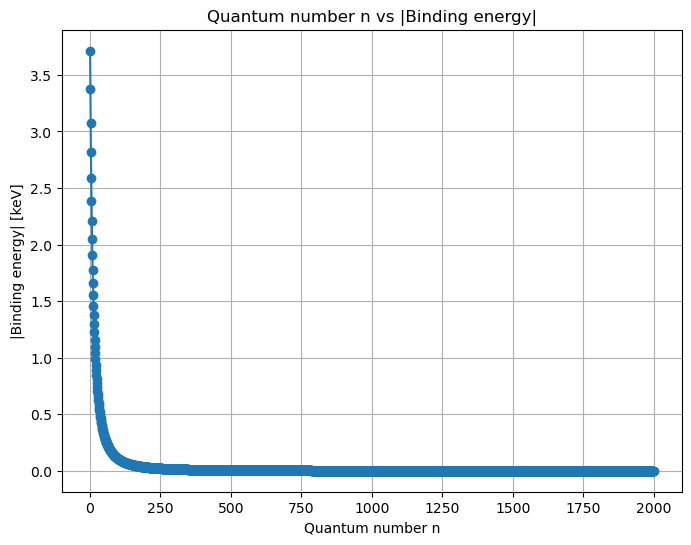

In [52]:
# 3. Binding Energy vs. Quantum Number
binding_energy = np.abs(energy_levels)
quantum_numbers = np.arange(1, num_samples + 1)
plt.figure(figsize=(8, 6))
plt.plot(quantum_numbers, binding_energy, marker='o', linestyle='-')
plt.xlabel('Quantum number n')
plt.ylabel('|Binding energy| [keV]')
plt.title('Quantum number n vs |Binding energy|')
plt.grid(True)
plt.show()

63/63 [==============================] - 0s 323us/step


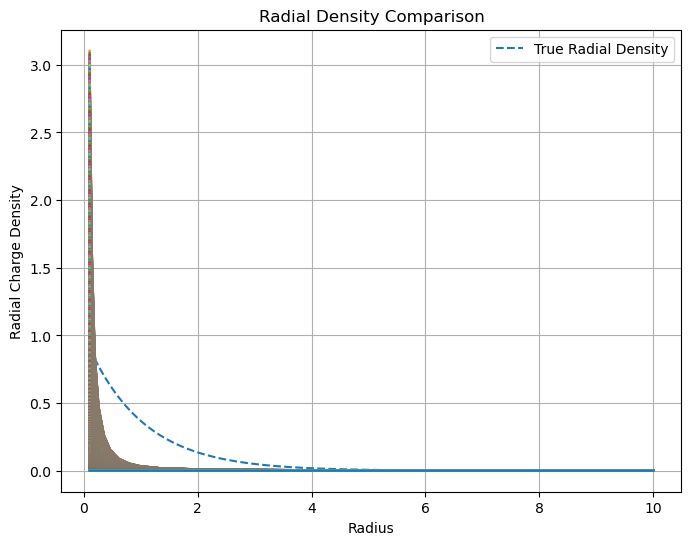

In [53]:
# 4. Radial Density Comparison
plt.figure(figsize=(8, 6))
plt.plot(r_true, radial_density_true, label='True Radial Density', linestyle='--')
# plt.plot(r_true, calculate_radial_density(model.predict(X_train), r_true), label='Predicted Radial Density', linestyle='-')
plt.plot(r_true, calculate_radial_density(model.predict(X_train), r_true), linestyle='-')
plt.xlabel('Radius')
plt.ylabel('Radial Charge Density')
plt.title('Radial Density Comparison')
plt.legend()
plt.grid(True)
plt.show()

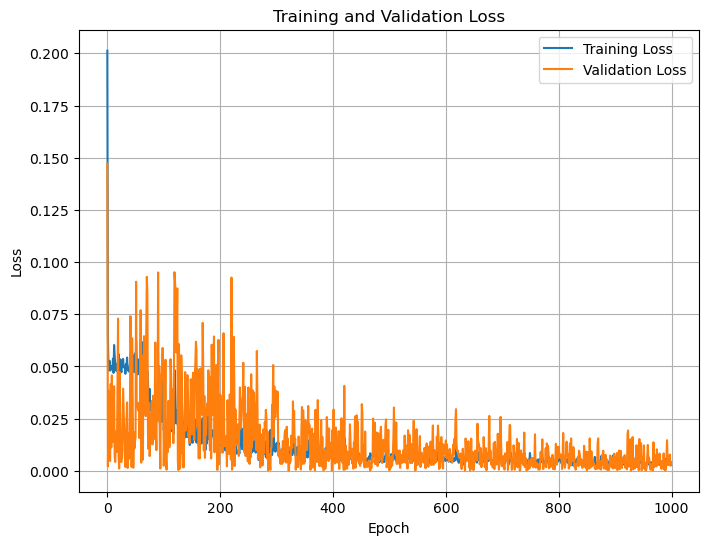

In [54]:
# 5. Loss Function Behavior
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

63/63 [==============================] - 0s 320us/step


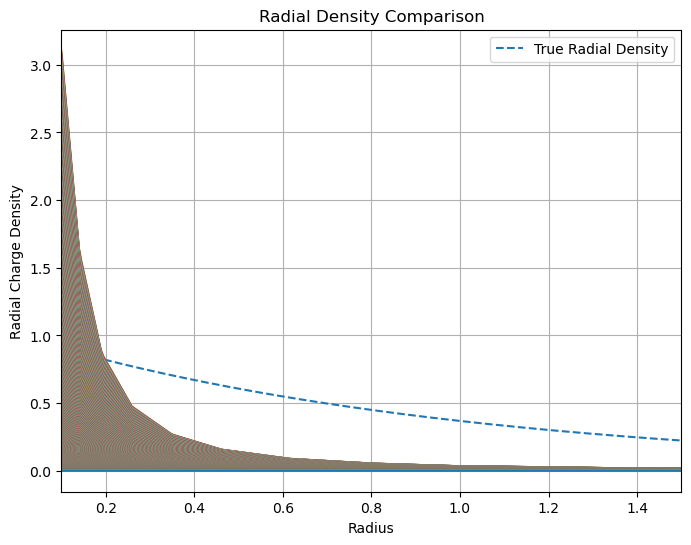

In [58]:
# 4. Radial Density Comparison
plt.figure(figsize=(8, 6))
plt.plot(r_true, radial_density_true, label='True Radial Density', linestyle='--')
# plt.plot(r_true, calculate_radial_density(model.predict(X_train), r_true), label='Predicted Radial Density', linestyle='-')
plt.plot(r_true, calculate_radial_density(model.predict(X_train), r_true), linestyle='-')
plt.xlabel('Radius')
plt.ylabel('Radial Charge Density')
plt.title('Radial Density Comparison')
plt.legend()
plt.grid(True)

# Set x-axis limits
plt.xlim(0.1,1.5)

plt.show()
